This notebook implements method 2 for matrix factorization (using stochastic gradient descent with bias terms for each user and movie) and enables visualization of the resulting latent factors.

In [1]:
import numpy as np
import os
import pickle
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
font_kwargs = {'family': 'sans-serif',
               'sans-serif': 'Arial',
               'size': 12}
plt.rc('font', **font_kwargs)
mathtext_kwargs = {'fontset': 'custom',
                   'bf': 'Arial:bold',
                   'cal': 'Arial:italic',
                   'it': 'Arial:italic',
                   'rm': 'Arial'}
plt.rc('mathtext', **mathtext_kwargs)
savefig_kwargs = {'dpi': 300, 'bbox_inches': 'tight',
                  'transparent': True}
plt.rc('pdf', fonttype=42)
#%config InlineBackend.figure_format = 'pdf'
%config InlineBackend.print_figure_kwargs = savefig_kwargs

First, we define functions to train a model with <i>k</i> latent factors, identifying <i>k</i>&times;<i>m</i> matrix U and <i>k</i>&times;<i>n</i> matrix V representing the <i>m</i> users and <i>n</i> movies.

In [3]:
def grad(Y_ij, U_i, V_j, a_i, b_j, mu=0, reg=0):
    '''
    Takes as input training point Y_ij (rating of ith user for
    jth movie), user vector U_i (ith column of U), movie vector
    V_j (jth column of V), user deviation a_i, and movie deviation
    b_j, with optional arguments for global bias mu (assumed to be
    0 by default) and regularization strength reg (set to 0 by
    default).
    
    Returns the gradients of the regularized squared loss function
    with respect to U_i, V_j, a_i, and b_j.
    '''
    grad_U = reg * U_i - (Y_ij - mu - np.dot(U_i, V_j) - a_i - b_j) * V_j
    grad_V = reg * V_j - (Y_ij - mu - np.dot(U_i, V_j) - a_i - b_j) * U_i
    grad_a = reg * a_i - (Y_ij - mu - np.dot(U_i, V_j) - a_i - b_j)
    grad_b = reg * b_j - (Y_ij - mu - np.dot(U_i, V_j) - a_i - b_j)
    
    return grad_U, grad_V, grad_a, grad_b

def err(Y, U, V, a, b, mu=None, reg=0):
    '''
    Takes as input Y, a matrix where each row (i, j, Y_ij) gives the
    rating Y_ij of user i for movie j; U, a matrix of shape (k, m)
    where each column represents one of the m users; V, a matrix of
    shape (k, n) where each column represents one of the n movies;
    a, a vector of shape (m, ) where each value represents the
    user-specific deviation from the global mean; b, a vector of shape
    (n, ) where each value represents the movie-specific deviation from
    the global mean; mu, a scalar giving the global bias for ratings
    (computed from Y if set to None); and reg, a scalar giving the
    regularization strength (set to 0 by default).
    
    Returns the mean regularized squared error for predictions made
    by estimating Y_ij as the dot product of the ith column of U and
    the jth column of V (accounting for global, user, and movie biases).
    '''
    # Compute term for regularization
    err_r = reg * (np.linalg.norm(U) + np.linalg.norm(V) +
                   np.linalg.norm(a) + np.linalg.norm(b)) / 2
    
    # Compute term for squared loss
    if mu is None:
        mu = np.mean(Y_ij[:, -1])
    resid = np.array([Y_ij - mu - np.dot(U[:, i], V[:, j]) - a[i] - b[j]
                      for (i, j, Y_ij) in Y])
    err_s = np.sum(resid ** 2) / 2
    
    # Return mean regularized squared error
    return (err_r + err_s) / len(Y)

def process_Y(Y_in):
    '''
    Takes as input Y_in, a matrix where each row (i, j, Y_ij) gives the
    rating Y_ij of user i for movie j.
    
    Returns Y, a matrix of the same size as Y_in where user and movie IDs
    have been mapped to sorted indices (lowest value has index 0, etc.),
    as well as the mappings inds_U and inds_V, where the value of the ith
    element is the index corresponding to ID i (or -1 if i is not an ID).
    '''
    Y = np.zeros(Y_in.shape)
    
    # Map user and movie IDs to indices
    ids_U = np.unique(Y_in[:, 0]).astype(int)
    inds_U = -np.ones(np.max(ids_U) + 1)
    for i, id_U in enumerate(ids_U):
        inds_U[id_U] = i
    inds_U = inds_U.astype(int)
    ids_V = np.unique(Y_in[:, 1]).astype(int)
    inds_V = -np.ones(np.max(ids_V).astype(int) + 1)
    for i, id_V in enumerate(ids_V):
        inds_V[id_V] = i
    inds_V = inds_V.astype(int)
    
    # Convert IDs in Y_in to indices
    for r, (i, j, Y_ij) in enumerate(Y_in):
        Y[r] = [inds_U[i], inds_V[j], Y_ij]
    Y = Y.astype(int)
    
    return Y, inds_U, inds_V
    
def train_model(Y_in, k, m=None, n=None, reg=0, eta=0.01,
                eps=0.0001, max_epochs=300):
    '''
    Takes as input Y_in, a matrix where each row (i, j, Y_ij) gives the
    rating Y_ij of user i for movie j; k, the number of latent factors;
    m, the number of users (inferred from Y if set to None); n, the
    number of movies (inferred from Y if set to None); reg, the strength
    of regularization (set to 0 by default); eta, the learning rate
    (set to 0.01 by default); eps, the minimum improvement in mean
    regularized squared error at each epoch as a proportion of the
    improvement after the first epoch (set to 0.0001 by default); and
    max_epochs, the maximum number of epochs (set to 300 by default).
    
    Returns trained latent factor model given by matrices U and V and
    bias vectors a and b, along with the unregularized mean squared error
    of the model.
    '''
    Y, _, _ = process_Y(Y_in)
    
    # Extract numbers of users and movies if needed
    if m is None:
        m = len(np.unique(Y[:, 0]))
    if n is None:
        n = len(np.unique(Y[:, 1]))
    
    # Initialize entries of U, V, a, and b to random numbers in [-0.5, 0.5]
    U = np.random.random((k, m)) - 0.5
    V = np.random.random((k, n)) - 0.5
    a = np.random.random(m) - 0.5
    b = np.random.random(n) - 0.5
    mu = np.mean(Y[:, -1])
    
    # Store loss (regularized mean squared error) for each epoch
    loss = np.empty(max_epochs + 1)
    loss[0] = err(Y, U, V, a, b, mu, reg)
    
    # Perform SGD for specified number of epochs (or until termination)
    for epoch in range(max_epochs):
        # Shuffle data
        np.random.shuffle(Y)
        
        # Update U, V, a, and b for each data point
        for (i, j, Y_ij) in Y:
            grad_U, grad_V, grad_a, grad_b = \
                grad(Y_ij, U[:, i], V[:, j], a[i], b[j], mu=mu, reg=reg)
            U[:, i] -= eta * grad_U
            V[:, j] -= eta * grad_V
            a[i] -= eta * grad_a
            b[j] -= eta * grad_b
        
        # Compute loss and check for stopping condition
        loss[epoch + 1] = err(Y, U, V, a, b, mu, reg)
        if (loss[epoch + 1] - loss[epoch]) <= eps * (loss[1] - loss[0]):
            break
    
    # Compute unregularized mean squared error for final model
    err_model = err(Y, U, V, a, b, mu, reg=0)
    return U, V, a, b, err_model

We can use this framework to train our model for the MovieLens dataset.  We start by reading in the data.

In [4]:
# Read in data on ratings
ratings = pd.read_csv(os.path.join('data', 'data.txt'),
                      sep='\t', header=None,
                      names=['User ID', 'Movie ID', 'Rating'])
Y_train = pd.read_csv(os.path.join('data', 'train.txt'),
                      sep='\t', header=None,
                      names=['User ID', 'Movie ID', 'Rating'])
Y_test = pd.read_csv(os.path.join('data', 'test.txt'),
                     sep='\t', header=None,
                     names=['User ID', 'Movie ID', 'Rating'])

# Read in information on movies
names = ['Movie ID', 'Movie Title', 'Unknown', 'Action',
         'Adventure', 'Animation', 'Children\'s', 'Comedy',
         'Crime', 'Documentary', 'Drama', 'Fantasy',
         'Film-Noir', 'Horror', 'Musical', 'Mystery',
         'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv(os.path.join('data', 'movies.txt'),
                     sep='\t', header=None,
                     encoding='latin_1', names=names)
movies['Movie Title'] = movies['Movie Title'].str.strip()

# Separate movie name and year if desired
split_year = False
if split_year:
    movies.loc[266, 'Movie Title'] = 'unknown (0000)'
    movies.loc[1411, 'Movie Title'] = \
        'Land Before Time III: The Time of the Great Giving (V) (1995)'
    movies['Year'] = [int(title[-5:-1]) for title in movies['Movie Title']]
    movies['Movie Title'] = [title[:-7] for title in movies['Movie Title']]

# Merge ratings data with movie metadata
data = ratings.merge(movies, how='left', on='Movie ID')
data_train = Y_train.merge(movies, how='left', on='Movie ID')
data_test = Y_test.merge(movies, how='left', on='Movie ID')

We then perform hyperparameter selection for regularization strength and learning rate using the training data, selecting 10% of the data to be used as a validation set.

Optimal hyperparameters: regularization strength 0.3 and learning rate 0.03


<Figure size 216x216 with 0 Axes>

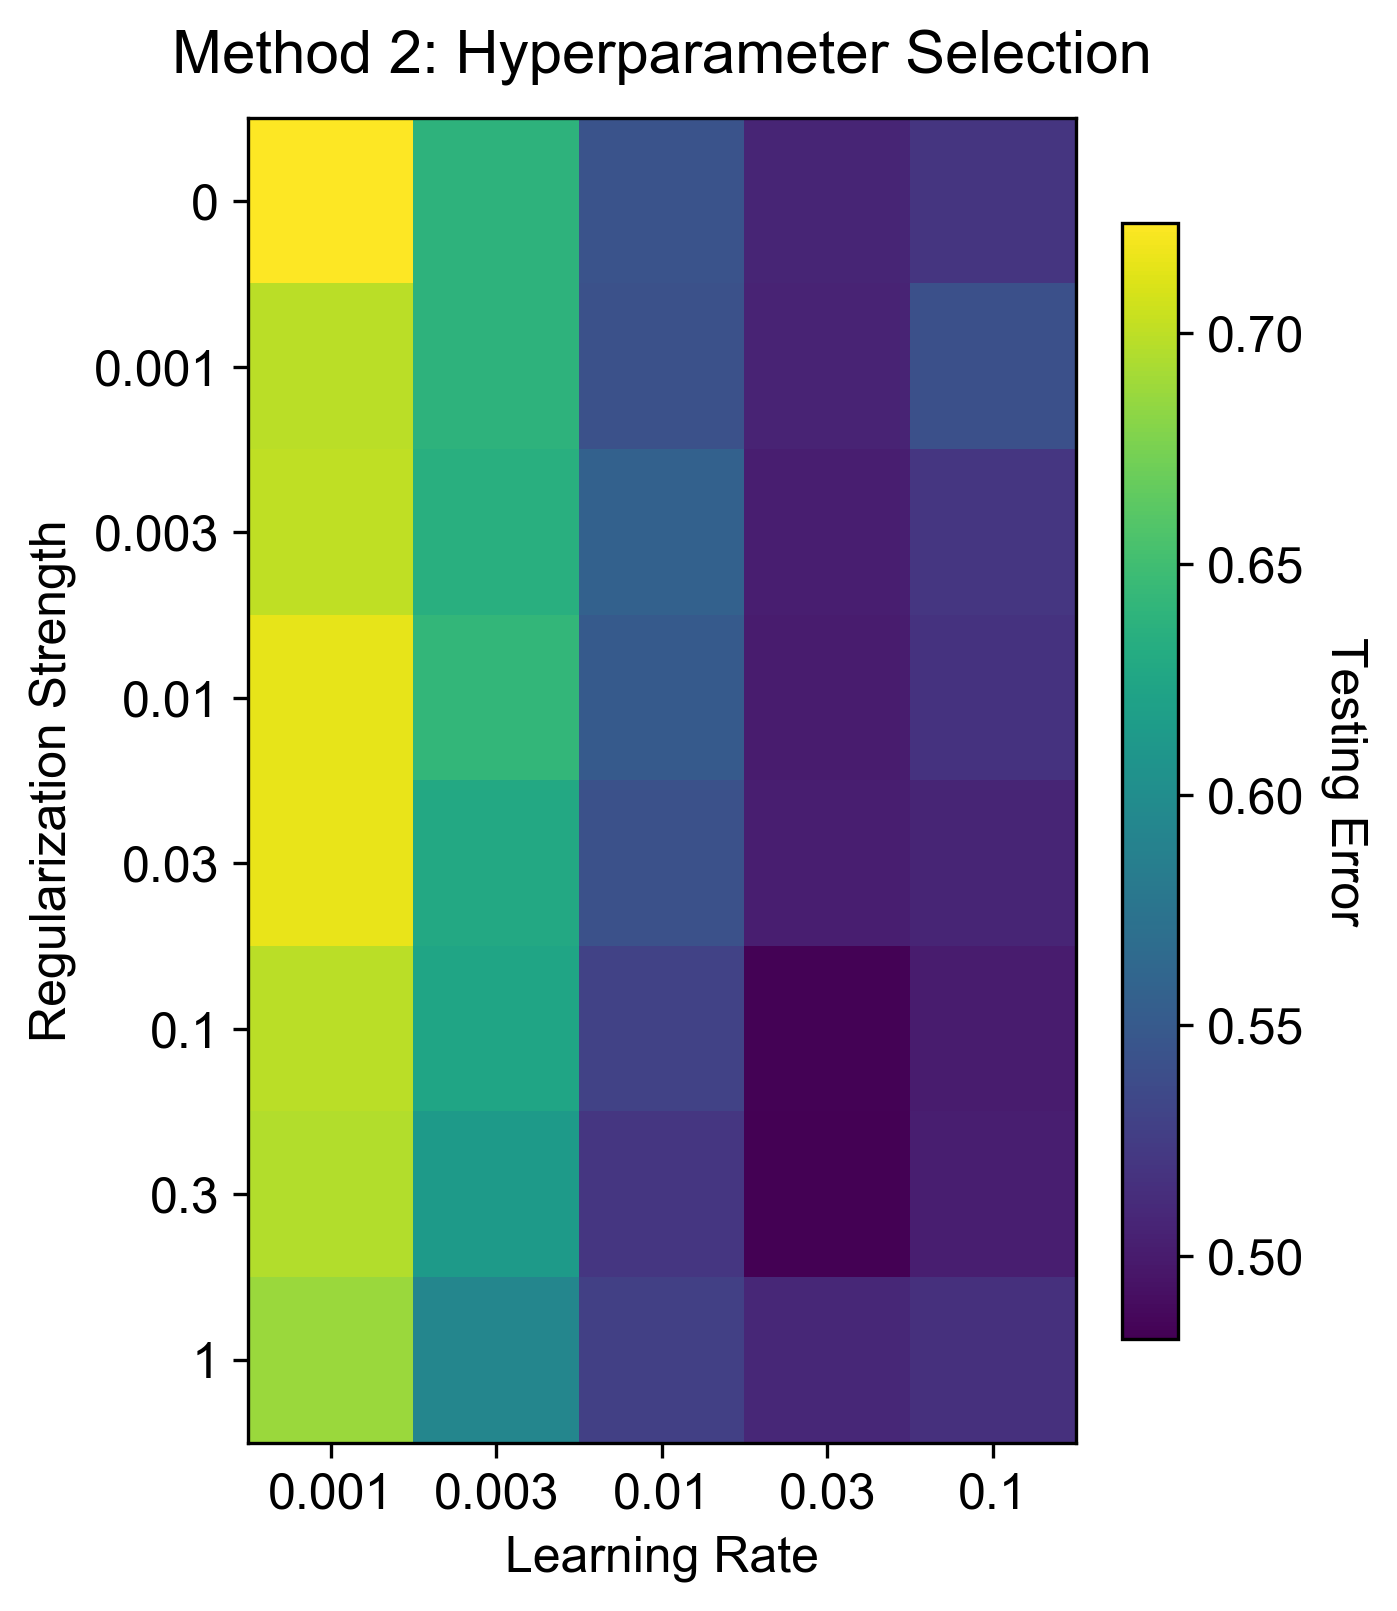

In [5]:
# Specify regularization strengths and learning rates to test
regs = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1]
etas = [0.001, 0.003, 0.01, 0.03, 0.1]

# Specify number of latent factors
k = 20

# Create training and validation sets
np.random.seed(36)
Y_all, _, _ = process_Y(Y_train.values)
np.random.shuffle(Y_all)
n_train = int(0.9 * len(Y_all))
Y_all_train = Y_all[:n_train]
Y_all_test = Y_all[n_train:]

# Save training and testing errors
err_train = np.zeros((len(regs), len(etas)))
err_test = np.zeros((len(regs), len(etas)))

# Train model for each set of hyperparameters
mu = np.mean(Y_all_train[:, -1])
for i, reg in enumerate(regs):
    for j, eta in enumerate(etas):
        U, V, a, b, err_model = train_model(Y_all_train, k=k,
                                            m = len(np.unique(Y_all[:, 0])),
                                            n = len(np.unique(Y_all[:, 1])),
                                            reg=reg, eta=eta,
                                            eps=0.0001, max_epochs=300)
        err_train[i, j] = err_model
        err_test[i, j] = err(Y_all_test, U, V, a, b, mu=mu, reg=reg)

# Visualize testing error for each set of hyperparameters
plt.figure(figsize=(3, 3))
plt.matshow(err_test)
plt.yticks(np.arange(len(regs)), regs)
plt.ylabel('Regularization Strength')
plt.xticks(np.arange(len(etas)), etas)
plt.tick_params('x', top=False, labeltop=False,
                bottom=True, labelbottom=True)
plt.xlabel('Learning Rate')
cb = plt.colorbar(fraction=0.06)
cb.set_label('Testing Error', rotation=270, labelpad=15)
plt.title('Method 2: Hyperparameter Selection', pad=-5);
        
# Select hyperparameters that yield the lowest testing error
i, j = np.unravel_index(np.argmin(err_test), err_test.shape)
reg = regs[i]
eta = etas[j]
print('Optimal hyperparameters: regularization strength', reg,
      'and learning rate', eta)

We can now use these optimized hyperparameters to train the model on the full training set.

In [6]:
# Process training and testing sets
Y_all, inds_U, inds_V = process_Y(np.vstack((Y_train.values, Y_test.values)))
Y_all_train = Y_all[:len(Y_train)]
Y_all_test = Y_all[len(Y_train):]

# Train model for best set of hyperparameters
mu = np.mean(Y_all_train[:, -1])
U, V, a, b, err_train = train_model(Y_all_train, k=k,
                                    m = len(np.unique(Y_all[:, 0])),
                                    n = len(np.unique(Y_all[:, 1])),
                                    reg=reg, eta=eta,
                                    eps=0.0001, max_epochs=300)

# Save results
with open('method2.pkl', 'wb') as file:
    pickle.dump((U, V, a, b, inds_U, inds_V), file)

# Evaluate performance on testing set
err_test = err(Y_all_test, U, V, a, b, mu=mu, reg=reg)
print('Training error:', err_train)
print('Testing error:', err_test)

Training error: 0.4431390700245053
Testing error: 0.4685566722634634


Having trained a model with strong performance and relatively little overfitting, we now seek to visualize and interpret the results.  Specifically, we use singular value decomposition (SVD) on V as V = A&Sigma;B and use the first two columns of A to project U and V into a two-dimensional space for visualization.

In [6]:
# Read in results
with open('method2.pkl', 'rb') as file:
    U, V, a, b, inds_U, inds_V = pickle.load(file)

# Perform SVD on V
A, S, B = np.linalg.svd(V, full_matrices=False)

# Project U and V into two-dimensional space
U_vis = A[:, :2].T @ U
V_vis = A[:, :2].T @ V

We can then visualize the projections of all movies into this latent space.

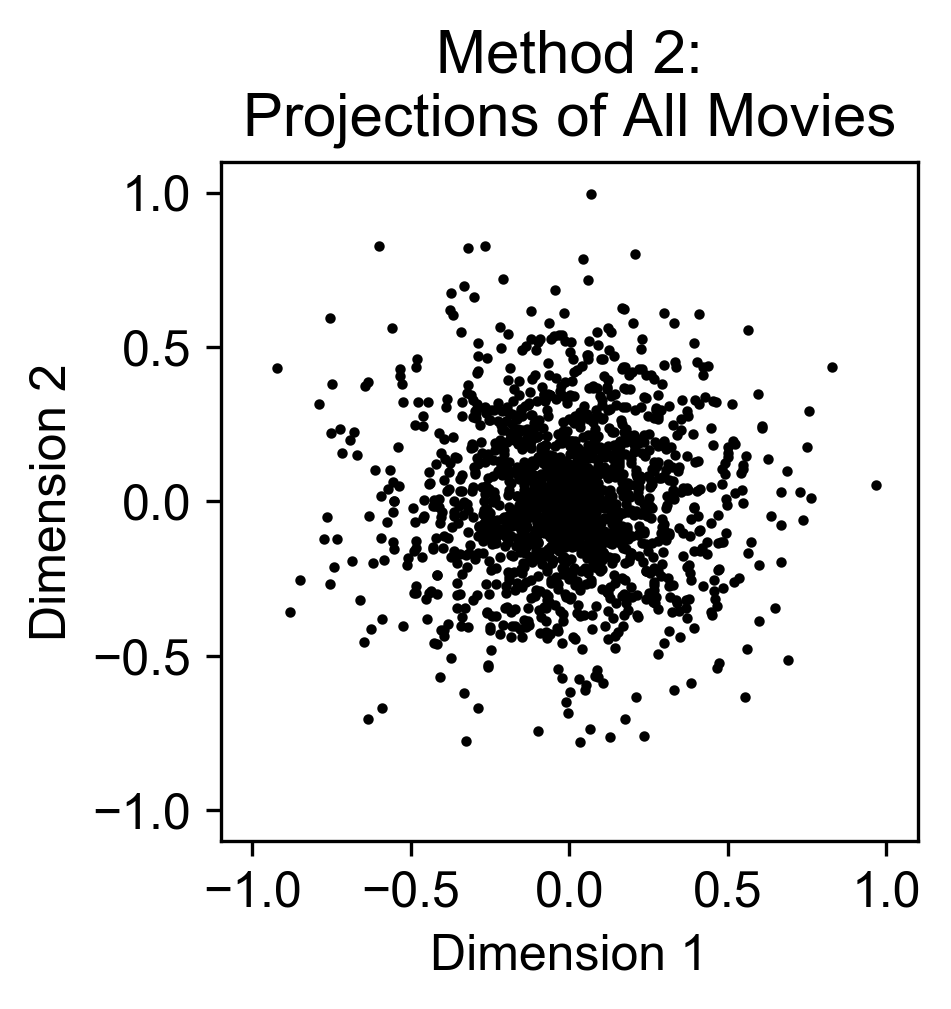

In [7]:
def label_plot(subtitle,
               xlim=[-1.1, 1.1], ylim=[-1.1, 1.1],
               xticks=np.arange(-1, 1.1, 0.5),
               yticks=np.arange(-1, 1.1, 0.5)):
    plt.xlim(xlim)
    plt.xticks(xticks)
    plt.ylim(ylim)
    plt.yticks(yticks)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Method 2:\n' + subtitle)

# Visualize projections of all movies
plt.figure(figsize=(3, 3))
plt.plot(V_vis[0], V_vis[1], 'k.', ms=3)
label_plot('Projections of All Movies')

We choose ten specific movies to visualize in this space.

Nosferatu a Venezia (1986)
My Crazy Life (Mi vida loca) (1993)
Lashou shentan (1992)
New Age, The (1994)
Hollow Reed (1996)
Somebody to Love (1994)
One Night Stand (1997)
Incognito (1997)
Hana-bi (1997)
Toy Story (1995)


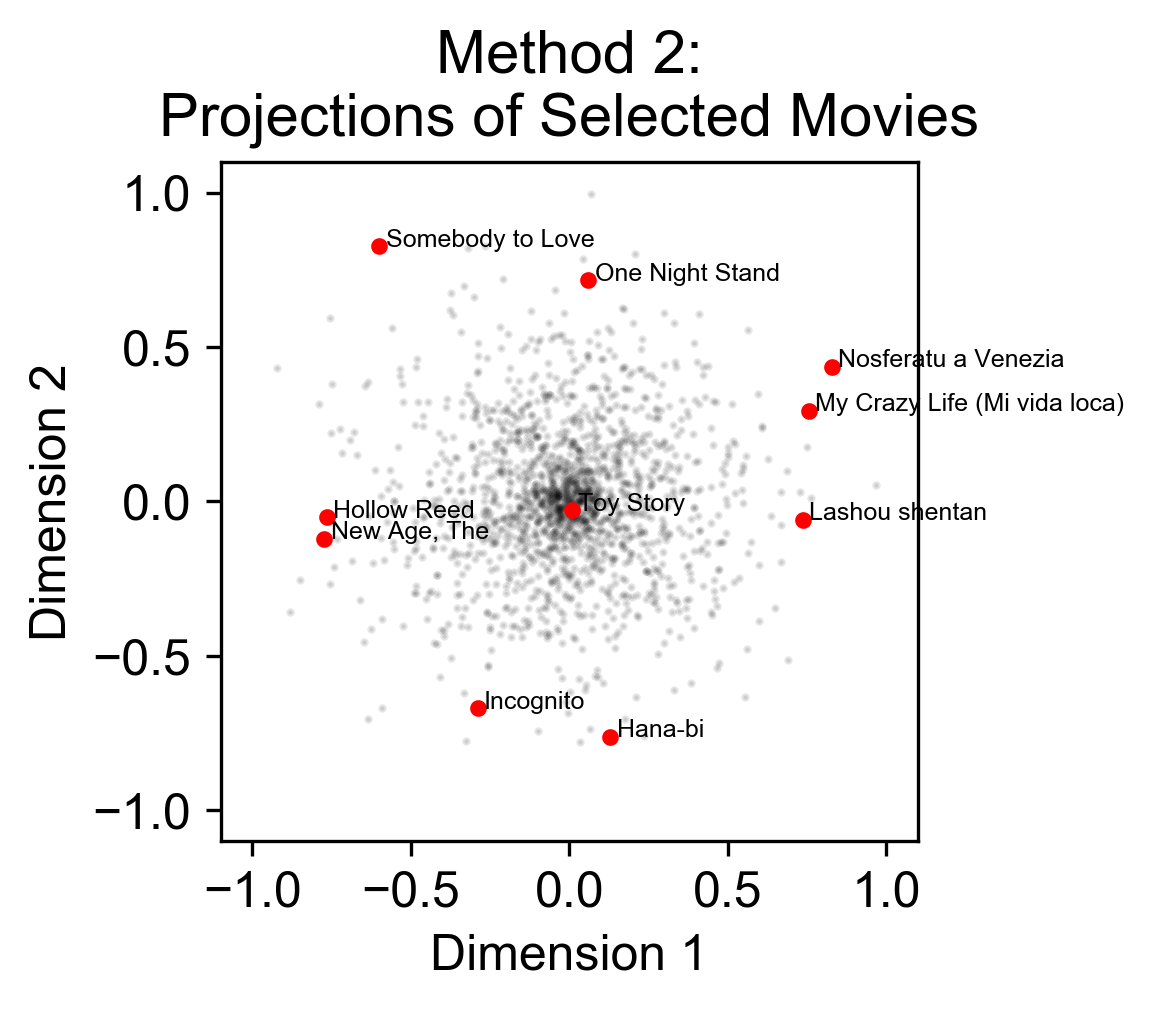

In [40]:
# Select IDs for movies of interest
movie_ids = [861, 1421, 1586, 1661, 1380, 1334, 888, 361, 1647, 1]

# Find indices of selected movie IDs
inds = [inds_V[movie_id] for movie_id in movie_ids]

# Visualize projections of selected movies
plt.figure(figsize=(3, 3))
plt.plot(V_vis[0], V_vis[1], 'k.', ms=2, alpha=0.1)
plt.plot(V_vis[0, inds], V_vis[1, inds], 'r.')
for ind in inds:
    print(movies.loc[ind, 'Movie Title'])
    plt.text(V_vis[0, ind] + 0.02, V_vis[1, ind],
             movies.loc[ind, 'Movie Title'][:-7],
             fontsize=6)
label_plot('Projections of Selected Movies');

We next consider the ten most popular movies.

Independence Day (ID4) (1996)
Air Force One (1997)
Toy Story (1995)
Scream (1996)
English Patient, The (1996)
Liar Liar (1997)
Return of the Jedi (1983)
Fargo (1996)
Contact (1997)
Star Wars (1977)


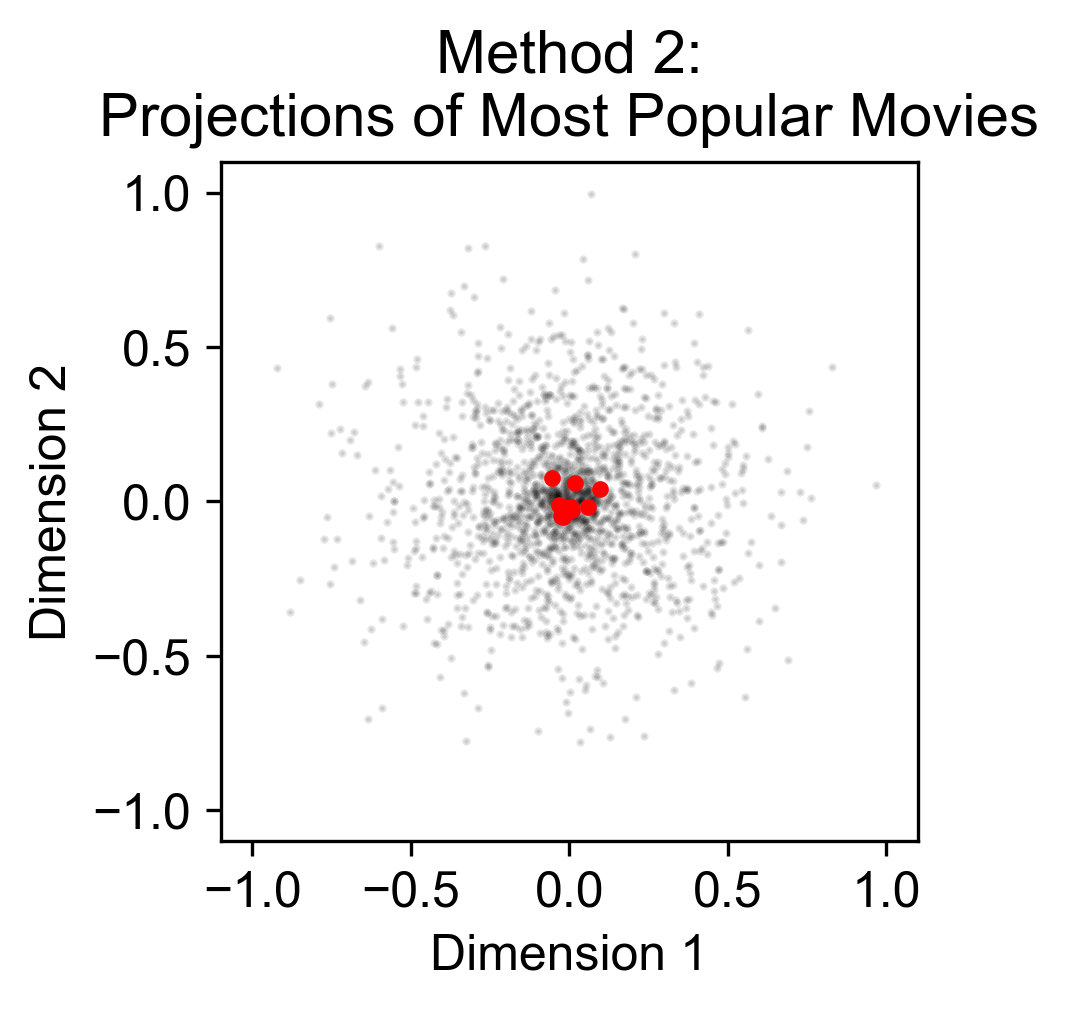

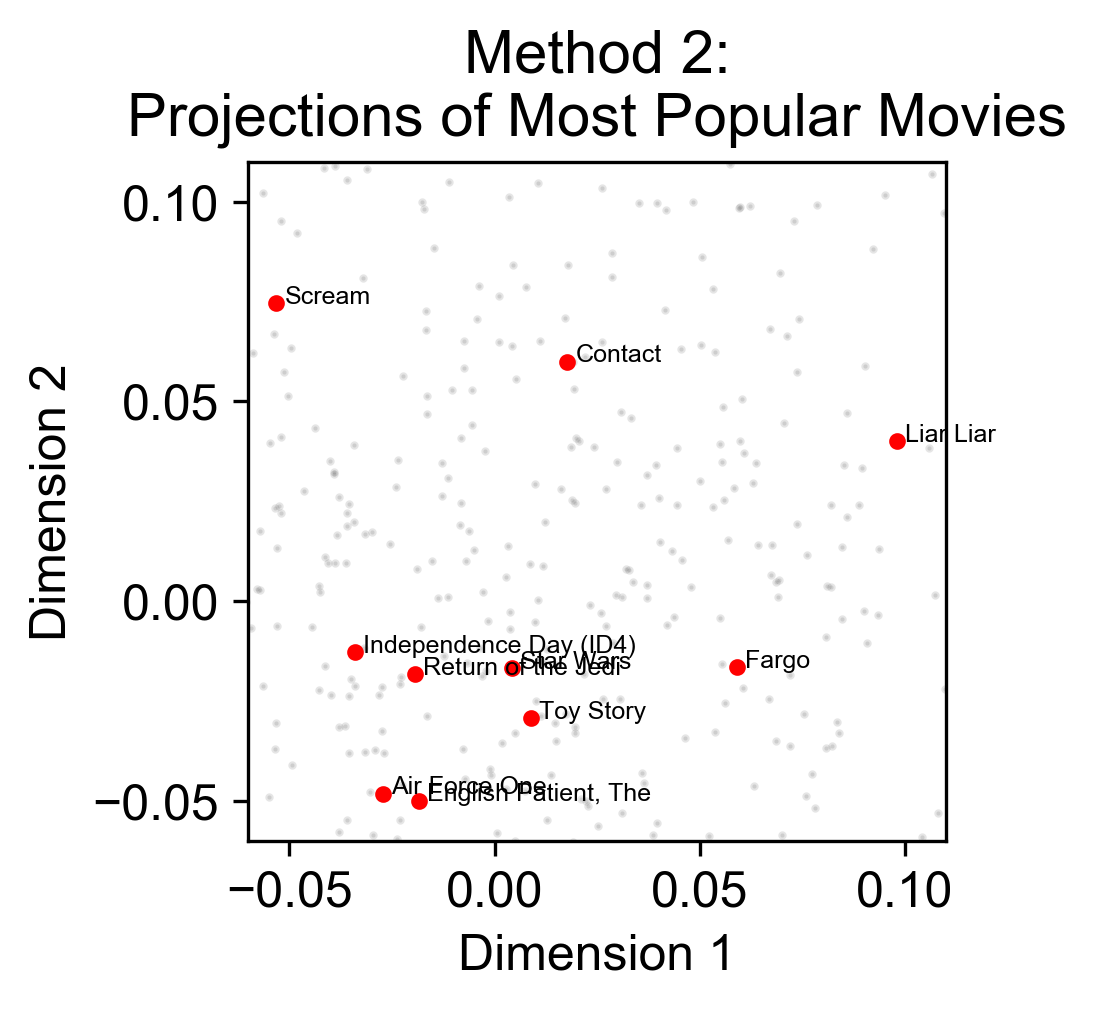

In [94]:
# Extract IDs of most popular movies
n = 10
ids, counts = np.unique(data['Movie ID'], return_counts=True)
movie_ids = ids[np.argsort(counts)[-n:]]

# Find indices of selected movie IDs
inds = [inds_V[movie_id] for movie_id in movie_ids]

# Visualize projections of most popular movies
plt.figure(figsize=(3, 3))
plt.plot(V_vis[0], V_vis[1], 'k.', ms=2, alpha=0.1)
plt.plot(V_vis[0, inds], V_vis[1, inds], 'r.')
label_plot('Projections of Most Popular Movies');

# Visualize projections of most popular movies (zoomed)
plt.figure(figsize=(3, 3))
plt.plot(V_vis[0], V_vis[1], 'k.', ms=2, alpha=0.1)
plt.plot(V_vis[0, inds], V_vis[1, inds], 'r.')
for ind in inds:
    print(movies.loc[ind, 'Movie Title'])
    plt.text(V_vis[0, ind] + 0.002, V_vis[1, ind],
             movies.loc[ind, 'Movie Title'][:-7],
             fontsize=6)
label_plot('Projections of Most Popular Movies',
           xlim=[-0.06, 0.11], ylim=[-0.06, 0.11],
           xticks=np.arange(-0.05, 0.11, 0.05),
           yticks=np.arange(-0.05, 0.11, 0.05))

We can also analyze the ten best movies.

Great Day in Harlem, A (1994)
Someone Else's America (1995)
Marlene Dietrich: Shadow and Light (1996)
They Made Me a Criminal (1939)
Entertaining Angels: The Dorothy Day Story (1996)
Star Kid (1997)
Santa with Muscles (1996)
Prefontaine (1997)
Aiqing wansui (1994)
Saint of Fort Washington, The (1993)


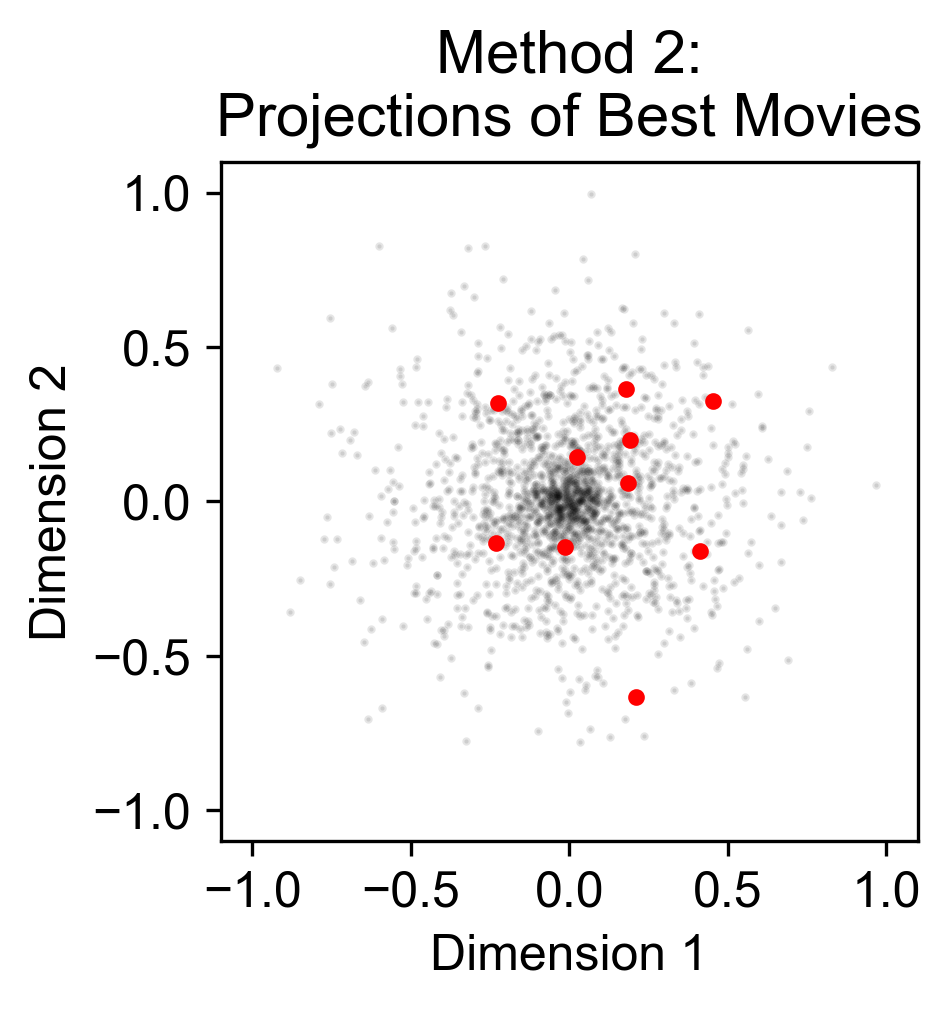

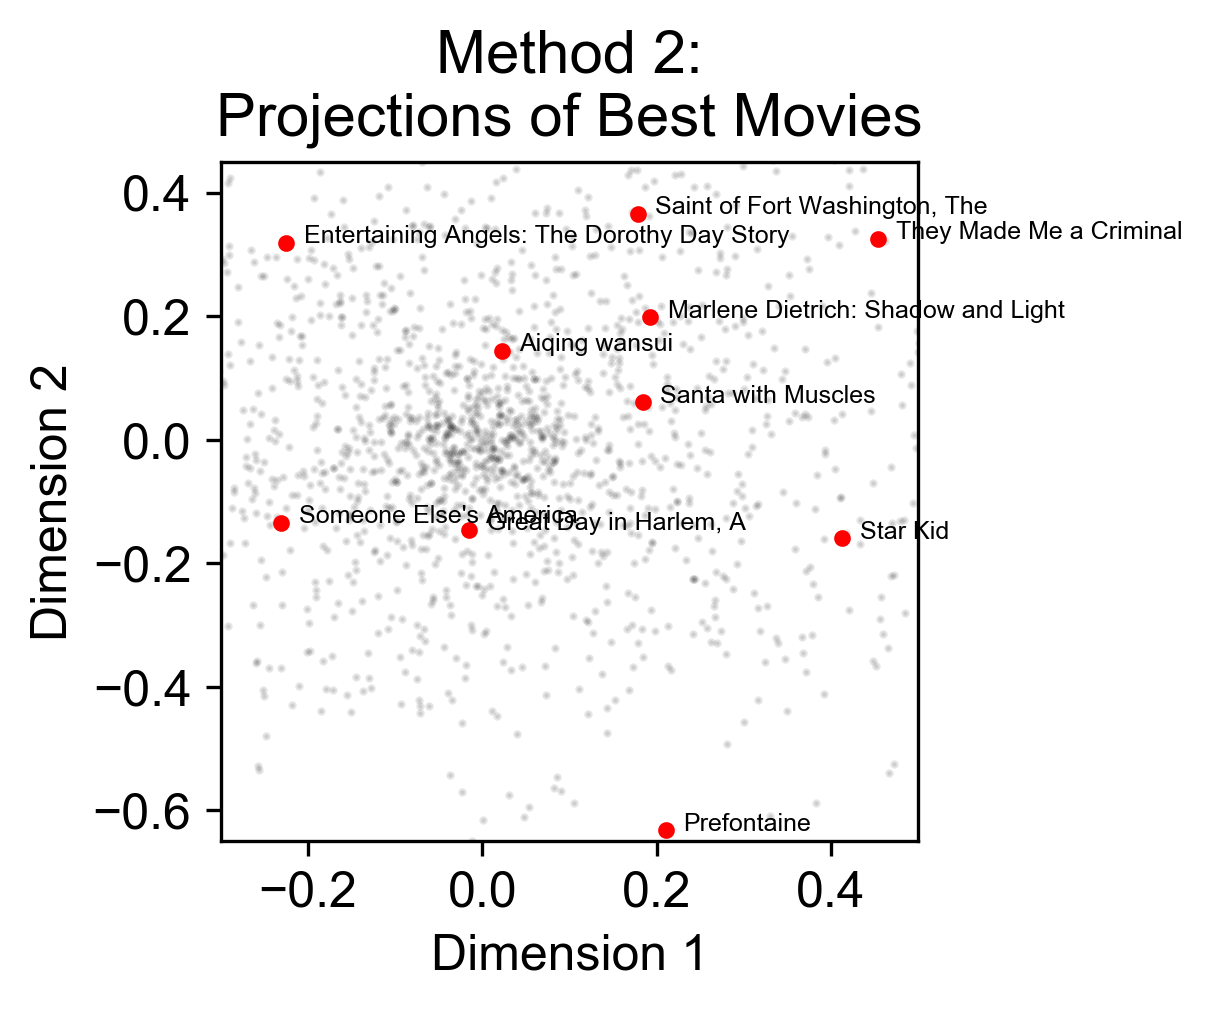

In [41]:
# Extract IDs of best movies
n = 10
mean_ratings = data[['Movie ID', 'Rating']].groupby(
    'Movie ID').agg('mean').reset_index()
movie_ids = mean_ratings.sort_values(
    'Rating', ascending=False)['Movie ID'][:n]

# Find indices of selected movie IDs
inds = [inds_V[movie_id] for movie_id in movie_ids]

# Visualize projections of best movies
plt.figure(figsize=(3, 3))
plt.plot(V_vis[0], V_vis[1], 'k.', ms=2, alpha=0.1)
plt.plot(V_vis[0, inds], V_vis[1, inds], 'r.')
label_plot('Projections of Best Movies');

# Visualize projections of best movies (zoomed)
plt.figure(figsize=(3, 3))
plt.plot(V_vis[0], V_vis[1], 'k.', ms=2, alpha=0.1)
plt.plot(V_vis[0, inds], V_vis[1, inds], 'r.')
for ind in inds:
    print(movies.loc[ind, 'Movie Title'])
    plt.text(V_vis[0, ind] + 0.02, V_vis[1, ind],
             movies.loc[ind, 'Movie Title'][:-7],
             fontsize=6)
label_plot('Projections of Best Movies',
           xlim=[-0.3, 0.5], ylim=[-0.65, 0.45],
           xticks=np.arange(-0.2, 0.5, 0.2),
           yticks=np.arange(-0.6, 0.45, 0.2))

Finally, we consider three specific genres.

In [42]:
genre = 'Crime'
movie_ids = [movies['Movie ID'][i] for i in range(len(movies['Movie ID']))
             if movies[genre][i] == 1]